In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_csv("../data/train_ratings.csv")

### normalize

In [ ]:
# ratebeer['review_score'] = ratebeer.groupby('profile_name')['review_score'].transform(lambda x: ((x - x.min() + 1e-6) / (x.max() - x.min() + 1e-6)))

### 맥주 점수 분포 체크

In [3]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559177 entries, 0 to 1559176
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1559177 non-null  int64  
 1   item    1559177 non-null  int64  
 2   time    1559177 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 35.7 MB


In [4]:
ratebeer['user'].value_counts()

604      3262
568      3150
603      2823
595      2808
1262     2755
         ... 
10318       2
29431       2
25360       2
21031       2
17226       2
Name: user, Length: 21478, dtype: int64

In [5]:
ratebeer['item'].nunique()

9274

### preprocessing

In [6]:
def preprocessing_df(df):

    
    # item, user, rating만 추출
    # df = df[['beer_id', 'profile_name', 'review_score', 'image_url']]
    # df.rename(columns={'beer_id' : 'item', 'profile_name' : 'user', 'review_score' : 'rating'}, inplace = True) 
    
    df['rating'] = 1
#     df['rating_median'] = df.groupby('user')['rating'].transform('median')
#     df.loc[df['rating'] > df['rating_median'], 'rating'] = 1
#     df.loc[df['rating'] <= df['rating_median'], 'rating'] = 0
    
    # 유저 리뷰 수 개산
#     df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
#     # 리뷰 수가 10개 이상인 유저만 남김 
#     df = df[(df['user/reviewcount'] >= 10)]
    
#     df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

In [288]:
# ratebeer[ratebeer['profile_name']=='Ungstrup']['review_score'].hist()

### Statistics of the Dataset

In [7]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 21478, number of items: 9274
matrix sparsity: 0.992172
   user    item          time  rating
0     0   94349  1.334980e+09       1
1     0  113934  1.335147e+09       1
2     0  116128  1.335417e+09       1
3     0   13324  1.335584e+09       1
4     0   59023  1.335765e+09       1


### 한국 편의점 맥주만

In [8]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])

data = data[data['item'].isin(kor_beer_list)]

### Label Encoding

In [9]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

num_users = data.user.nunique()
num_items = data.item.nunique()
# data.drop(columns=['user', 'item_id'], inplace=True)

In [10]:
num_users, num_items

(8704, 75)

### Loading the data

In [11]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.9
        self.val_size = 0.1
        # self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
#         n_test = int(self.num_users * self.test_size)
        
        np.random.seed(42)
        
        val_indices = set(np.random.choice(range(self.num_users), n_val, replace = False))
        # test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices # - test_indices

        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
#         else:
#             self.df = self.df[self.df['user_id_idx'].isin(test_indices)]
        
        
        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating
            

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [12]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.2):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.activate = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.activate(self.encoder(mat)))
        pred = self.activate(self.decoder(hidden))
        
        return pred

###  Model train, validation

In [13]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0
    loss_cal_count = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        if not np.isnan(loss.cpu().detach().numpy()):
            loss_cal_count += 1
            loss_sum += loss.item()
            
    loss_avg = loss_sum / loss_cal_count

    return loss_avg

In [14]:
def validation(model, valid_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
      
    loss_avg = loss_sum / loss_cal_count

    return loss_avg

In [15]:
class AutoRec_loss_fn(nn.Module):

    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute > 0) # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 16

PATH = '../model/autorec_implicit_korean_test.pt'
patience = 5

num_items = data.item_id_idx.nunique()
num_hidden = 40

In [17]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [18]:
model = AutoRec(num_hidden, num_items).to(device)
# loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
# loss = nn.BCEWithLogitsLoss().to(device)
loss = nn.BCELoss().to(device)
optm = optim.Adam(model.parameters(),lr=lr)

In [19]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

  2%|▎               | 1/50 [00:04<03:51,  4.73s/it]

Validation loss decreased (inf --> 0.057656).  Saving model ...
epoch: 0, train Loss: 0.1807, test Loss: 0.0577


  4%|▋               | 2/50 [00:08<03:24,  4.26s/it]

Validation loss decreased (0.057656 --> 0.033841).  Saving model ...
epoch: 1, train Loss: 0.1017, test Loss: 0.0338


  6%|▉               | 3/50 [00:12<03:11,  4.08s/it]

Validation loss decreased (0.033841 --> 0.022363).  Saving model ...
epoch: 2, train Loss: 0.0872, test Loss: 0.0224


  8%|█▎              | 4/50 [00:16<03:03,  4.00s/it]

Validation loss decreased (0.022363 --> 0.017232).  Saving model ...
epoch: 3, train Loss: 0.0777, test Loss: 0.0172


 10%|█▌              | 5/50 [00:20<02:59,  3.98s/it]

Validation loss decreased (0.017232 --> 0.013977).  Saving model ...
epoch: 4, train Loss: 0.0676, test Loss: 0.0140


 12%|█▉              | 6/50 [00:24<02:55,  3.99s/it]

Validation loss decreased (0.013977 --> 0.010608).  Saving model ...
epoch: 5, train Loss: 0.0580, test Loss: 0.0106


 14%|██▏             | 7/50 [00:28<02:51,  3.98s/it]

Validation loss decreased (0.010608 --> 0.008223).  Saving model ...
epoch: 6, train Loss: 0.0500, test Loss: 0.0082


 16%|██▌             | 8/50 [00:32<02:47,  3.98s/it]

Validation loss decreased (0.008223 --> 0.006620).  Saving model ...
epoch: 7, train Loss: 0.0439, test Loss: 0.0066


 18%|██▉             | 9/50 [00:36<02:42,  3.95s/it]

Validation loss decreased (0.006620 --> 0.005493).  Saving model ...
epoch: 8, train Loss: 0.0391, test Loss: 0.0055


 20%|███            | 10/50 [00:40<02:39,  3.98s/it]

Validation loss decreased (0.005493 --> 0.004686).  Saving model ...
epoch: 9, train Loss: 0.0357, test Loss: 0.0047


 22%|███▎           | 11/50 [00:44<02:33,  3.94s/it]

Validation loss decreased (0.004686 --> 0.004117).  Saving model ...
epoch: 10, train Loss: 0.0329, test Loss: 0.0041


 24%|███▌           | 12/50 [00:47<02:29,  3.92s/it]

Validation loss decreased (0.004117 --> 0.003700).  Saving model ...
epoch: 11, train Loss: 0.0305, test Loss: 0.0037


 26%|███▉           | 13/50 [00:51<02:24,  3.92s/it]

Validation loss decreased (0.003700 --> 0.003370).  Saving model ...
epoch: 12, train Loss: 0.0285, test Loss: 0.0034


 28%|████▏          | 14/50 [00:56<02:23,  3.99s/it]

Validation loss decreased (0.003370 --> 0.003058).  Saving model ...
epoch: 13, train Loss: 0.0268, test Loss: 0.0031


 30%|████▌          | 15/50 [00:59<02:19,  3.98s/it]

Validation loss decreased (0.003058 --> 0.002843).  Saving model ...
epoch: 14, train Loss: 0.0254, test Loss: 0.0028


 32%|████▊          | 16/50 [01:03<02:15,  3.98s/it]

Validation loss decreased (0.002843 --> 0.002636).  Saving model ...
epoch: 15, train Loss: 0.0241, test Loss: 0.0026


 34%|█████          | 17/50 [01:07<02:11,  3.98s/it]

Validation loss decreased (0.002636 --> 0.002459).  Saving model ...
epoch: 16, train Loss: 0.0231, test Loss: 0.0025


 36%|█████▍         | 18/50 [01:11<02:08,  4.00s/it]

Validation loss decreased (0.002459 --> 0.002315).  Saving model ...
epoch: 17, train Loss: 0.0223, test Loss: 0.0023


 38%|█████▋         | 19/50 [01:16<02:04,  4.03s/it]

Validation loss decreased (0.002315 --> 0.002181).  Saving model ...
epoch: 18, train Loss: 0.0211, test Loss: 0.0022


 40%|██████         | 20/50 [01:20<01:59,  3.99s/it]

Validation loss decreased (0.002181 --> 0.002074).  Saving model ...
epoch: 19, train Loss: 0.0204, test Loss: 0.0021


 42%|██████▎        | 21/50 [01:23<01:55,  3.99s/it]

Validation loss decreased (0.002074 --> 0.001961).  Saving model ...
epoch: 20, train Loss: 0.0197, test Loss: 0.0020


 44%|██████▌        | 22/50 [01:28<01:55,  4.11s/it]

Validation loss decreased (0.001961 --> 0.001869).  Saving model ...
epoch: 21, train Loss: 0.0192, test Loss: 0.0019


 46%|██████▉        | 23/50 [01:32<01:51,  4.14s/it]

Validation loss decreased (0.001869 --> 0.001790).  Saving model ...
epoch: 22, train Loss: 0.0186, test Loss: 0.0018


 48%|███████▏       | 24/50 [01:36<01:46,  4.10s/it]

Validation loss decreased (0.001790 --> 0.001709).  Saving model ...
epoch: 23, train Loss: 0.0179, test Loss: 0.0017


 50%|███████▌       | 25/50 [01:40<01:41,  4.06s/it]

Validation loss decreased (0.001709 --> 0.001647).  Saving model ...
epoch: 24, train Loss: 0.0176, test Loss: 0.0016


 52%|███████▊       | 26/50 [01:44<01:36,  4.04s/it]

Validation loss decreased (0.001647 --> 0.001586).  Saving model ...
epoch: 25, train Loss: 0.0171, test Loss: 0.0016


 54%|████████       | 27/50 [01:48<01:34,  4.12s/it]

Validation loss decreased (0.001586 --> 0.001529).  Saving model ...
epoch: 26, train Loss: 0.0166, test Loss: 0.0015


 56%|████████▍      | 28/50 [01:52<01:29,  4.07s/it]

Validation loss decreased (0.001529 --> 0.001482).  Saving model ...
epoch: 27, train Loss: 0.0162, test Loss: 0.0015


 58%|████████▋      | 29/50 [01:56<01:24,  4.03s/it]

Validation loss decreased (0.001482 --> 0.001438).  Saving model ...
epoch: 28, train Loss: 0.0159, test Loss: 0.0014


 60%|█████████      | 30/50 [02:00<01:20,  4.00s/it]

Validation loss decreased (0.001438 --> 0.001396).  Saving model ...
epoch: 29, train Loss: 0.0156, test Loss: 0.0014


 62%|█████████▎     | 31/50 [02:04<01:17,  4.06s/it]

Validation loss decreased (0.001396 --> 0.001361).  Saving model ...
epoch: 30, train Loss: 0.0154, test Loss: 0.0014


 64%|█████████▌     | 32/50 [02:08<01:12,  4.02s/it]

Validation loss decreased (0.001361 --> 0.001329).  Saving model ...
epoch: 31, train Loss: 0.0151, test Loss: 0.0013


 66%|█████████▉     | 33/50 [02:12<01:08,  4.01s/it]

Validation loss decreased (0.001329 --> 0.001293).  Saving model ...
epoch: 32, train Loss: 0.0149, test Loss: 0.0013


 68%|██████████▏    | 34/50 [02:16<01:03,  3.99s/it]

Validation loss decreased (0.001293 --> 0.001266).  Saving model ...
epoch: 33, train Loss: 0.0148, test Loss: 0.0013


 70%|██████████▌    | 35/50 [02:20<01:00,  4.05s/it]

Validation loss decreased (0.001266 --> 0.001240).  Saving model ...
epoch: 34, train Loss: 0.0145, test Loss: 0.0012


 72%|██████████▊    | 36/50 [02:24<00:56,  4.02s/it]

Validation loss decreased (0.001240 --> 0.001215).  Saving model ...
epoch: 35, train Loss: 0.0142, test Loss: 0.0012


 74%|███████████    | 37/50 [02:28<00:52,  4.01s/it]

Validation loss decreased (0.001215 --> 0.001190).  Saving model ...
epoch: 36, train Loss: 0.0139, test Loss: 0.0012


 76%|███████████▍   | 38/50 [02:32<00:48,  4.03s/it]

Validation loss decreased (0.001190 --> 0.001172).  Saving model ...
epoch: 37, train Loss: 0.0138, test Loss: 0.0012


 78%|███████████▋   | 39/50 [02:37<00:44,  4.06s/it]

Validation loss decreased (0.001172 --> 0.001149).  Saving model ...
epoch: 38, train Loss: 0.0137, test Loss: 0.0011


 80%|████████████   | 40/50 [02:41<00:40,  4.03s/it]

Validation loss decreased (0.001149 --> 0.001129).  Saving model ...
epoch: 39, train Loss: 0.0133, test Loss: 0.0011


 82%|████████████▎  | 41/50 [02:45<00:36,  4.01s/it]

Validation loss decreased (0.001129 --> 0.001112).  Saving model ...
epoch: 40, train Loss: 0.0130, test Loss: 0.0011


 84%|████████████▌  | 42/50 [02:49<00:32,  4.01s/it]

Validation loss decreased (0.001112 --> 0.001097).  Saving model ...
epoch: 41, train Loss: 0.0130, test Loss: 0.0011


 86%|████████████▉  | 43/50 [02:53<00:28,  4.02s/it]

Validation loss decreased (0.001097 --> 0.001081).  Saving model ...
epoch: 42, train Loss: 0.0130, test Loss: 0.0011


 88%|█████████████▏ | 44/50 [02:57<00:25,  4.25s/it]

Validation loss decreased (0.001081 --> 0.001064).  Saving model ...
epoch: 43, train Loss: 0.0126, test Loss: 0.0011


 90%|█████████████▌ | 45/50 [03:02<00:22,  4.43s/it]

Validation loss decreased (0.001064 --> 0.001054).  Saving model ...
epoch: 44, train Loss: 0.0126, test Loss: 0.0011


 92%|█████████████▊ | 46/50 [03:06<00:17,  4.29s/it]

Validation loss decreased (0.001054 --> 0.001041).  Saving model ...
epoch: 45, train Loss: 0.0122, test Loss: 0.0010


 94%|██████████████ | 47/50 [03:10<00:12,  4.21s/it]

Validation loss decreased (0.001041 --> 0.001027).  Saving model ...
epoch: 46, train Loss: 0.0121, test Loss: 0.0010


 96%|██████████████▍| 48/50 [03:14<00:08,  4.15s/it]

Validation loss decreased (0.001027 --> 0.001017).  Saving model ...
epoch: 47, train Loss: 0.0120, test Loss: 0.0010


 98%|██████████████▋| 49/50 [03:18<00:04,  4.10s/it]

Validation loss decreased (0.001017 --> 0.001006).  Saving model ...
epoch: 48, train Loss: 0.0120, test Loss: 0.0010


100%|███████████████| 50/50 [03:22<00:00,  4.05s/it]

Validation loss decreased (0.001006 --> 0.000995).  Saving model ...
epoch: 49, train Loss: 0.0118, test Loss: 0.0010


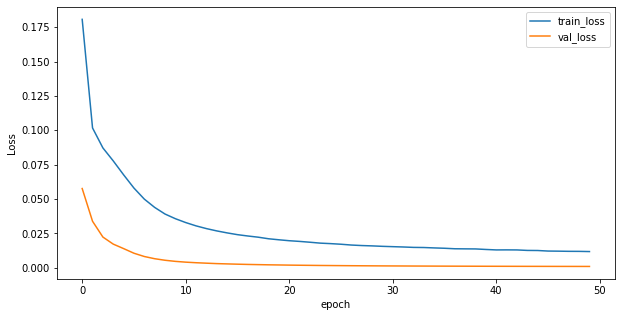

In [20]:
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience = patience, verbose = True, path=PATH)

for epoch in tqdm(range(num_epochs)):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 모델 불러오기

In [21]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### test

In [22]:
test_data = pd.read_csv("../data/test_file.csv")

In [23]:
test_data['rating'] = 1

In [24]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])
test_data = test_data[test_data['item'].isin(kor_beer_list)]

In [25]:
user_le = LabelEncoder()
# item_le = LabelEncoder()
test_data['user_id_idx'] = user_le.fit_transform(test_data['user'].values)
test_data['item_id_idx'] = item_le.transform(test_data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

In [26]:
test_users = torch.tensor(test_data['user_id_idx'].values)
test_items = torch.tensor(test_data['item_id_idx'].values)
test_ratings = torch.tensor(test_data['rating'].values)

def make_inter_mat():
    inter_mat = np.zeros((num_users, num_items))
    for user, item, rating in zip(test_users, test_items, test_ratings):
        inter_mat[user][item] = rating

    return inter_mat

inter_mat = make_inter_mat()

### 평가지표

In [27]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    if len(actual):
        return res / float(len(actual))
    else:
        return 0

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set):
        if len(act_set) == 0:
            print('1')
        sum_recall = len(act_set & pred_set) / float(len(act_set))
    else:
        sum_recall = 0
    return sum_recall

In [28]:
inter_mat[0].shape[0]

75

In [29]:
np.zeros(75)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [30]:
topk = 10
ndcg_sum = 0
recall_sum = 0
ndcg_count = 0
recall_count = 0

for x_ans in inter_mat:
    x_ans = torch.tensor(x_ans, dtype = torch.float32).to(device)
    
    # answers = x_ans.cpu().numpy().argsort()[x_ans.cpu().numpy() == 1][-topk:][::-1]
    answers = x_ans.cpu().numpy().argsort()[-topk:][::-1]
    
    # print(answers)
    # x_test = torch.tensor(np.zeros(x_ans.shape[0]), dtype = torch.float32).to(device)
    x_test = np.ones(x_ans.shape[0])
    x_test[x_ans.cpu().numpy() == 0] = 0
    x_test[answers] = 0

    x_test = torch.tensor(x_test, dtype = torch.float32).to(device)
    
    # 모델 에측 맥주 평점
    rating_pred = model(x_test)

    rating_pred = rating_pred.cpu().data.numpy().copy()
    
    # user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

    # if novelty:
    # 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
    # rating_pred_kor[x_test_kor.cpu().numpy() == rating_list[0]] = rating_pred_kor.min()
    # rating_pred_kor[x_test_kor.cpu().numpy() == rating_list[2]] = rating_pred_kor.min()
    rating_pred[x_ans.cpu().numpy() > 0] = rating_pred.min()
    # print(rating_pred)

    # topk 맥주 index
    ind = np.argpartition(rating_pred, -topk)[-topk:]
    # print(ind)

    # topk 맥주 index별 평점
    arr_ind = rating_pred[ind]
    # print(arr_ind)

    # 평점 기준으로 내림차순으로 정렬
    arr_ind_argsort = np.argsort(arr_ind)[::-1]
    # print(arr_ind_argsort)

    # rating 내림차순 모델 예측 topk 맥주 index 
    topk_pred_list = ind[arr_ind_argsort]
    # print(topk_pred_list)

    # rating 내림차순 모델 예측 맥주 평점 중 topk개
    topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
    # print(topk_rating_list)
    
    ndcg = ndcg_k_inf(answers, topk_pred_list, topk)
    recall = recall_at_k_inf(answers, topk_pred_list, topk)

    if ndcg != 0:
        ndcg_count += 1
        ndcg_sum += ndcg
        
    if recall != 0:
        recall_count += 1
        recall_sum += recall
        
ndcg_sum /= ndcg_count
recall_sum /= recall_count

print(f'ndcg = {ndcg_sum}, recall@{topk} = {recall_sum}')

ndcg = 0.01737526765681298, recall@10 = 0.15735521833386165


In [203]:
# 웹사이트 input
# x_test = torch.tensor([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
#        3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
#        3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
#        3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. ]).to(device)


num_item = data['item'].nunique()

# 한국 맥주 평가
# rating_list = [5.0, 2.76, 0.5] # 좋아요, 몰라요, 싫어요

rating_list = [1.0, 0, 0] # 좋아요, 몰라요, 싫어요
# show_list = np.random.choice(data['item_id_idx'].unique(), 29, replace=False) # 임의로 29개 추출

# beer_pick = [473, 37, 268, 390, 729, 86387, 1478, 730] # 민철님
# beer_pick = [730, 268685, 37] #칭따오, 타이거, 블루문, 블랑, # 아현님 동생분
# beer_pick = [251, 2228, 473, 4007, 1267, 86387, 730] #경태
# beer_pick = [709, 1267, 37, 315443, 717] #동석님
# beer_pick = [4007, 72025, 37, 399, 390]
# beer_pick = [30913,  814, 4007, 37, 390, 717, 35424] #승태님
# beer_pick = [814, 135361, 73158, 632627, 86387]
beer_pick = [    37,     55, 390,    703,    715,
          729,    730,   1478,   1486,  34662,   2516, 169964]

x_test = torch.zeros(num_item).to(device) # 0으로 초기화

# for beer in show_list:
#     x_test[beer] = random.choice(rating_list) # 29개에 대해서 임의로 평가
    
for beer_id in beer_pick:
    beer = item_le.transform([beer_id])
    x_test[beer] = 1 
# 나머지 맥주 중 일부 평가
# not_kor_rating_list = [1.0, 0.67, 0.1]
# not_kor_idx = np.delete(np.arange(num_item), kor_beer_idx)
# not_kor_choice = np.random.randint(int(len(not_kor_idx) * 0.3))
# not_kor_list = np.random.choice(not_kor_idx, not_kor_choice , replace=False) 

# for beer in not_kor_list:
#     x_test[beer] = random.choice(not_kor_rating_list)

# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
    
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
#     # print(rating)



In [204]:
# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

# rating_pred_kor = rating_pred[kor_beer_idx]
# x_test_kor = x_test[kor_beer_idx]
# batch_user_index = user_ids.cpu().numpy()


answers = x_test.cpu().numpy().argsort()[-topk:][::-1]
# print(answers)

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
# 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
# rating_pred_kor[x_test.cpu().numpy() == rating_list[0]] = rating_pred_kor.min()
# rating_pred_kor[x_test_kor.cpu().numpy() == rating_list[2]] = rating_pred_kor.min()
rating_pred[x_test.cpu().numpy() > 0] = rating_pred.min()
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[ 7 20 11 32]
[0.43334734 0.41182187 0.35607636 0.34827417]


In [205]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([ 7, 20, 11, 32])

In [206]:
# 유저 실제 선호 맥주 top4
answers

array([ 0, 65, 23, 16])

In [207]:
rating_pred[topk_pred_list]

array([0.43334734, 0.41182187, 0.35607636, 0.34827417], dtype=float32)

In [184]:
# label_list = ['good', 'unknown', 'bad']

# for i, rating in enumerate(rating_list):
#     print(label_list[i])
#     print(list(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True)))
#     print()

In [110]:
# label_list = ['good', 'unknown', 'bad']

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# for i, rating in enumerate(rating_list):
    
#     ax = sns.kdeplot(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True), label = label_list[i], fill = True)

# plt.legend()
# plt.show()

<AxesSubplot:ylabel='Count'>

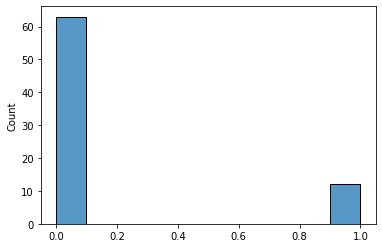

In [208]:
sns.histplot(x_test.cpu().numpy(), bins = 10)

<AxesSubplot:ylabel='Count'>

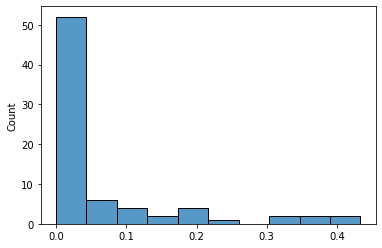

In [209]:
sns.histplot(rating_pred, bins = 10)

In [210]:
# 모델 예측 rating 점수
rating_pred

array([2.13596059e-06, 2.13596059e-06, 2.05742463e-01, 2.05139294e-01,
       1.06132030e-01, 2.13596059e-06, 6.35108008e-05, 4.33347344e-01,
       1.09308045e-02, 1.48976431e-03, 2.13596059e-06, 3.56076360e-01,
       2.13596059e-06, 5.81618911e-03, 1.48085570e-02, 2.13596059e-06,
       2.13596059e-06, 4.03156118e-05, 4.12428565e-03, 1.24990288e-03,
       4.11821872e-01, 8.69544744e-02, 2.13596059e-06, 2.13596059e-06,
       9.66112316e-03, 7.08344765e-03, 3.33477974e-01, 2.84164073e-03,
       2.13596059e-06, 1.98251959e-02, 3.18234973e-02, 7.68733844e-02,
       3.48274171e-01, 1.00680016e-01, 2.29564995e-01, 1.65104792e-01,
       1.99143603e-01, 1.47134781e-01, 2.34734714e-02, 1.15702100e-01,
       2.99282260e-02, 2.05453280e-02, 1.56423785e-02, 2.57082302e-02,
       2.05839779e-02, 2.79122125e-03, 1.06965229e-02, 2.13596059e-06,
       3.06446731e-01, 9.02055937e-04, 5.33594042e-02, 2.11292179e-03,
       4.82484959e-02, 6.95734546e-02, 1.07048440e-03, 2.10908905e-01,
      

In [211]:
x_test

tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')

In [212]:
beer_pick

[37, 55, 390, 703, 715, 729, 730, 1478, 1486, 34662, 2516, 169964]

In [213]:
# image url
[f'https://www.ratebeer.com/beer/{i}/' for i in data[data['item_id_idx'].isin(topk_pred_list)]['item'].unique()]

['https://www.ratebeer.com/beer/1267/',
 'https://www.ratebeer.com/beer/405/',
 'https://www.ratebeer.com/beer/3126/',
 'https://www.ratebeer.com/beer/709/']

In [202]:
data[['item', 'item_id_idx']].sort_values(by = ['item_id_idx']).groupby('item').head(1).to_csv('../data/ratebeer_item_label_encoding.csv', index = False)

### 평가지표 점수

In [92]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [93]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.25

In [94]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.04879750624901272

In [78]:
data

,item,user,rating,image_url,rating_median,user_id_idx,item_id_idx
3458,37,dunklermessias,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.66,5882,0
3460,37,bdleedahl,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.70,4821,0
3461,37,pictoman,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.70,8181,0
3462,37,IPARater72,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.66,1976,0
3463,37,2OLD4BS,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.66,28,0
...,...,...,...,...,...,...,...
2931600,8666,austinpowers,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.64,4721,41
2931601,8666,DavefromChicago,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.72,1102,41
2931602,8666,motelpogo,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.62,7756,41
2931603,8666,jbrus,0.0,https://res.cloudinary.com/ratebeer/image/uplo...,0.68,6737,41


In [97]:
data.to_csv('../data/ratebeer_implicit_label_encoding.csv', index = False)

### 리뷰 수 별 loss값 비교

In [ ]:
train Loss: 0.1429, test Loss: 0.3887, test rmse = 0.9741268377904415
train Loss: 0.1597, test Loss: 0.3982, test rmse = 0.9178506077363462
train Loss: 0.1498, test Loss: 0.3815, test rmse = 0.9185960203148705
train Loss: 0.1526, test Loss: 0.3700, test rmse = 0.8679648307799166
train Loss: 0.1647, test Loss: 0.3780, test rmse = 0.78464359338185
train Loss: 0.1535, test Loss: 0.3589, test rmse = 0.8115433694417444
train Loss: 0.1555, test Loss: 0.3459, test rmse = 0.8043579343771801

In [222]:
train_loss_list = [0.1429, 0.1597, 0.1498, 0.1526, 0.1647, 0.1535, 0.1555]
valid_loss_list = [0.3887, 0.3982, 0.3815, 0.3700, 0.3780, 0.3589, 0.3459]
test_loss_list = [0.9741, 0.9179, 0.9186, 0.8680, 0.7846, 0.8115, 0.8044]
review_n = [i for i in range(4, 11)]

In [224]:
train_loss_list = [i ** (1/2) for i in train_loss_list]
valid_loss_list = [i ** (1/2) for i in valid_loss_list]

In [228]:
train_loss_list

[0.378021163428716,
 0.3996248240537617,
 0.38704004960727256,
 0.3906404996924922,
 0.4058324777540605,
 0.39179076048319467,
 0.39433488306260706]

In [227]:
valid_loss_list

[0.6234580980306536,
 0.63103090257134,
 0.6176568626672904,
 0.6082762530298219,
 0.6148170459575759,
 0.5990826320300063,
 0.5881326381013045]

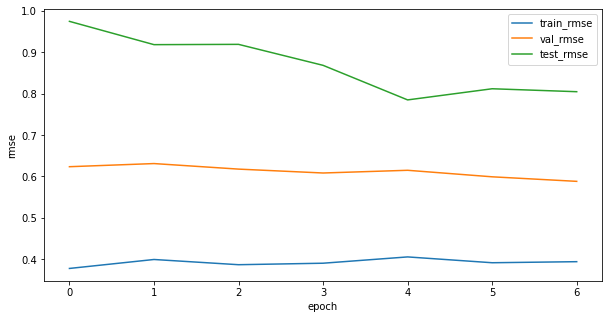

In [226]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_list,label="train_rmse")
plt.plot(valid_loss_list,label="val_rmse")
plt.plot(test_loss_list,label="test_rmse")
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.legend()
plt.show()